In [124]:
# Importamos las dependencias que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Bajamos el nivel de warning de TF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras import metrics

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.utils import compute_class_weight

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
ROOT = 'D:/HDD_Documents/Universidad/En_curso/MachineLearning/CelebA'
IMAGES_DIR = Path(os.path.join(ROOT, 'img_align_celeba'))

In [4]:
df_attributes = pd.read_csv(os.path.join(ROOT,'list_attr_celeba.csv'))
df_attributes.set_index('image_id')

df_partition = pd.read_csv(os.path.join(ROOT, 'list_eval_partition.csv'))
df_partition.set_index('image_id')

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,2
202596.jpg,2
202597.jpg,2


In [5]:
full = pd.merge(df_attributes, df_partition)
full = full[['image_id', 'No_Beard', 'partition']]
full.set_index('image_id')

,No_Beard,partition
image_id,,
000001.jpg,1,0
000002.jpg,1,0
000003.jpg,1,0
000004.jpg,1,0
000005.jpg,1,0
...,...,...
202595.jpg,1,2
202596.jpg,1,2
202597.jpg,1,2


In [6]:
full.loc[full['No_Beard'] == -1, 'No_Beard'] = 0 # Pasamos a 0 y 1 la feature No_Beard
full['No_Beard'] = full['No_Beard'].astype(str) # Lo paso a string para que el datagen no me de error

In [7]:
len(os.listdir(IMAGES_DIR))

202599

In [8]:
extensions = set()
for filename in os.listdir(IMAGES_DIR):
    extensions.add(Path(filename).suffix.lower())
    
extensions

{'.jpg'}

In [9]:
img = image.load_img(os.path.join(IMAGES_DIR, '000001.jpg'))
img.size, image.img_to_array(img).shape[2]
# ((ancho, alto), canales)

((178, 218), 3)

In [10]:
# Tenemos 202599 imágenes, todas en formato jpg
# Ancho: 178px - Alto: 218px - Canales: 3 (RGB)
# Cada imagen tiene  40 atributos asociados a través del ID, solamente vamos a usar el atributo No_Beard

(162770, 3) (19867, 3) (19962, 3)


<Axes: ylabel='count'>

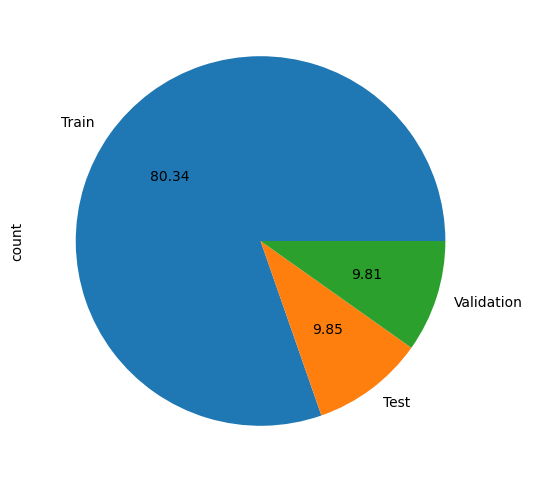

In [11]:
# Hacemos la separación en train, validation y test como se indica en el dataset 
df_train = full[full.partition == 0]
df_validation = full[full.partition == 1]
df_test = full[full.partition == 2]

print(df_train.shape, df_validation.shape, df_test.shape)
full.partition.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['Train', 'Test', 'Validation'])

<Axes: ylabel='count'>

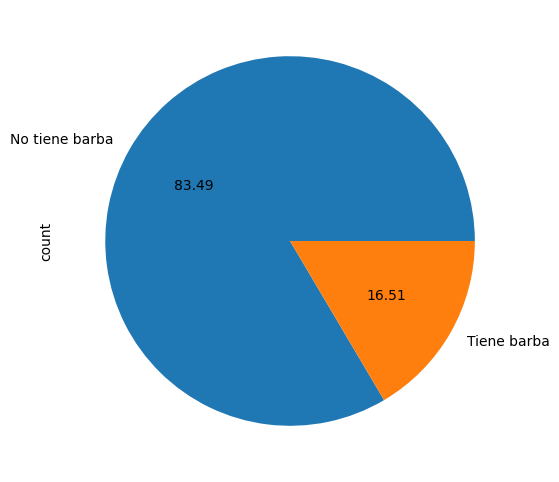

In [12]:
# Distribución en la totalidad del dataset
full.No_Beard.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['No tiene barba', 'Tiene barba'])

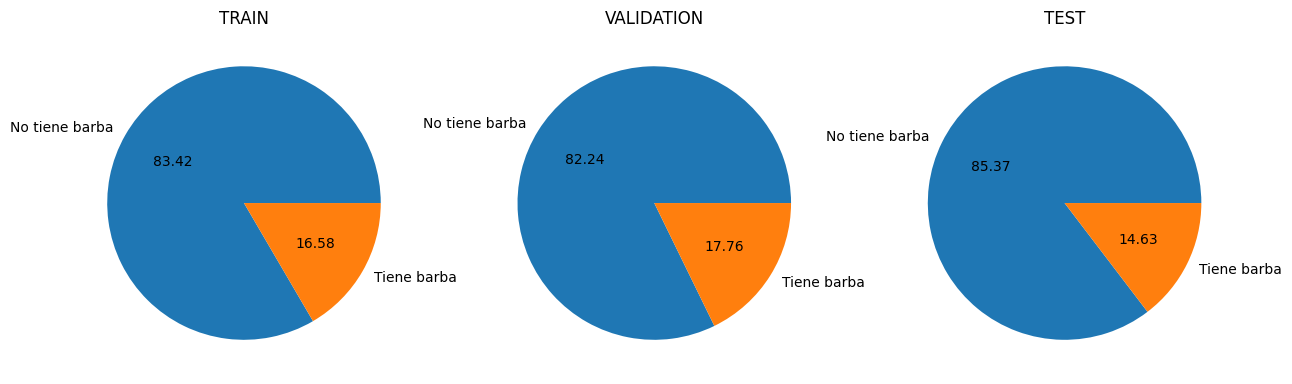

In [13]:
# Comparacion de la distribucion de 'No_Beard' en los tres subsets.
# Hacemos este análisis ya que no sabemos cómo hicieron la separación en los tres datasets,
# para ver si se mantiene la distribución de la variable de salida
fig, axis = plt.subplots(1,3, figsize=(15,10))
axis[0].pie(df_train.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[0].set_title('TRAIN')
axis[1].pie(df_validation.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[1].set_title('VALIDATION')
axis[2].pie(df_test.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[2].set_title('TEST')

plt.show()

In [14]:
# Creamos los datasets de keras
SIZE = 96 # Vamos a ir probando distintos tamaños... usaremos el mayor tamaño posible que se entrene en tiempo razonable

datagen = ImageDataGenerator(rescale=1./255)

GENERATOR_PARAMS = dict(
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
    color_mode="rgb",
)

train = datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS)

validation = datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS)

test = datagen.flow_from_dataframe(dataframe=df_test, **GENERATOR_PARAMS)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [15]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(np.where(labels[i] == 1, 'Sin barba', 'Con Barba'))
        plt.axis("off")

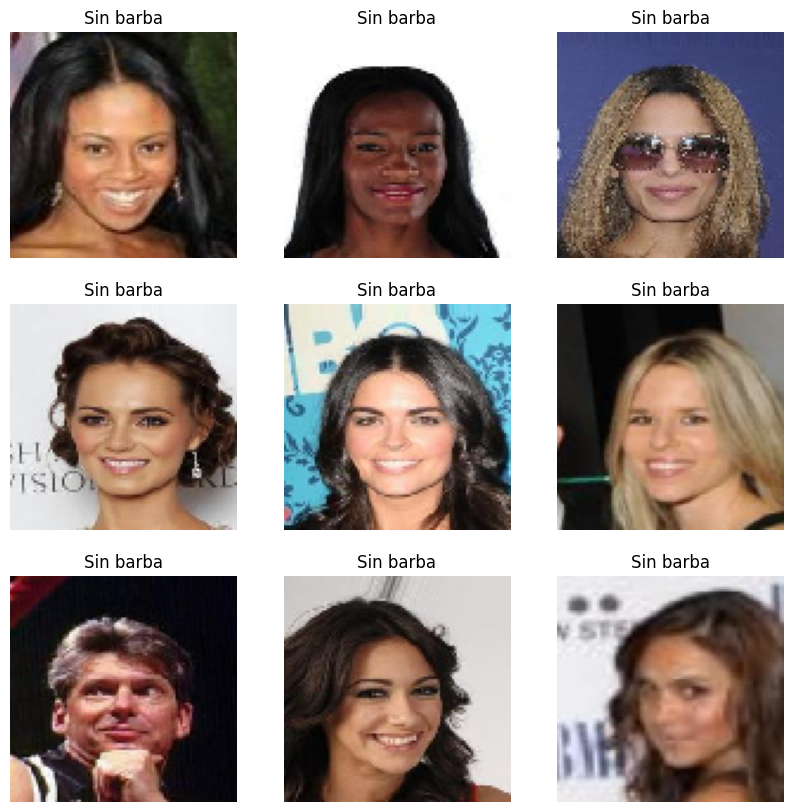

In [16]:
sample_images(test)

# Machine Learning

In [17]:
# Funciones a utilizar durante el entrenamiento para luego evaluar los modelos
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [18]:
def learning_curve(history):
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='validation')
  plt.title('Accuracy over train epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

In [19]:
import plotly.graph_objs as go

datasets = (
    ('train', datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS, batch_size=1000)),
    ('validation', datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS, batch_size=1000)),
)

def print_cofusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        batch_images, batch_labels = dataset.next()
        print('Samples:', len(batch_images))

        predictions = np.round(model.predict(batch_images)).flatten()
        labels = batch_labels
        
        print('Accuracy:', accuracy_score(labels, predictions))
        print('Precision:', precision_score(labels, predictions))

        VALORES = "Beard", "No Beard"
        
        heatmap = go.Heatmap(z=confusion_matrix(labels, predictions), x=VALORES, y=VALORES, colorscale='Blues')
        layout = go.Layout(title='Confusion Matrix',
                           width=480,
                           height=480,
                           xaxis=dict(
                            title="Predicted Value"
                           ),
                           yaxis=dict(
                            title="True Value"
                           ))
        fig = go.Figure(data=[heatmap], layout=layout)
        fig.show()

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.


In [58]:
BATCH_SIZE = 64

COMPILE_PARAMS = dict(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

train_samples = df_train.shape[0]
no_beard_class_weight = df_train[(df_train.No_Beard == '1')]['No_Beard'].value_counts()[0] / train_samples
beard_class_weight = df_train[(df_train.No_Beard == '0')]['No_Beard'].value_counts()[0] / train_samples

# Obtengo el peso que le vamos a asignar a cada clase a la hora de entrenar, para manejar el desbalance del target
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(train.classes),y=train.classes)
class_weights = dict(zip(np.unique(train.classes), class_weights))

FIT_PARAMS = dict(
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train)/BATCH_SIZE,
    validation_steps=len(validation)/BATCH_SIZE,
    validation_data=validation,
    callbacks=[OurCustomCallback()],
    class_weight = class_weights,
)

## Multi Layer Perceptron



In [59]:
# MLP

mlp_1_1 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='relu'),
    Dropout(0.25),
                                                # aca buscamos ver si hay mucha diferencia entre las funciones de activacion
    Dense(1, activation='sigmoid'),
])

mlp_1_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),), # a este modelo lo vamos a entrenar dos veces, una vez con 10 y otra con 20 epocas

    Dense(50, activation='relu'),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_3 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(60, activation='relu'),
    Dropout(0.25),
    Dense(40, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])
                                                # aca probamos otros modelos con mas capas ocultas para ver como funciona
mlp_4 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [60]:
#borrar
mlp_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),), # a este modelo lo vamos a entrenar dos veces, una vez con 10 y otra con 20 epocas

    Dense(50, activation='relu'),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [61]:
# Compilamos cada uno de los modelos MLP planteados y vemos el resumen
mlp_1_1.compile(**COMPILE_PARAMS) #relu

mlp_1_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 27648)             0         
                                                                 
 dense_22 (Dense)            (None, 100)               2764900   
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [62]:
history_mlp_1_1 = mlp_1_1.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 6s 73ms/step - loss: 1.9137 - accuracy: 0.6195 - val_loss: 0.6754 - val_accuracy: 0.5875
Epoch 2/15
79/79 [==============================] - 6s 69ms/step - loss: 0.6715 - accuracy: 0.6523 - val_loss: 0.7437 - val_accuracy: 0.4625
Epoch 3/15
79/79 [==============================] - 7s 83ms/step - loss: 0.6540 - accuracy: 0.6566 - val_loss: 0.5271 - val_accuracy: 0.8281
Epoch 4/15
79/79 [==============================] - 5s 65ms/step - loss: 0.6524 - accuracy: 0.6332 - val_loss: 0.6728 - val_accuracy: 0.6000
Epoch 5/15
79/79 [==============================] - 5s 67ms/step - loss: 0.6647 - accuracy: 0.2324 - val_loss: 0.6940 - val_accuracy: 0.2000
Epoch 6/15
79/79 [==============================] - 5s 64ms/step - loss: 0.6714 - accuracy: 0.4523 - val_loss: 0.6796 - val_accuracy: 0.8219
Epoch 7/15
79/79 [==============================] - 5s 67ms/step - loss: 0.6114 - accuracy: 0.7504 - val_loss: 0.5805 - val_accuracy: 0.7656
Epoch 8/15
79

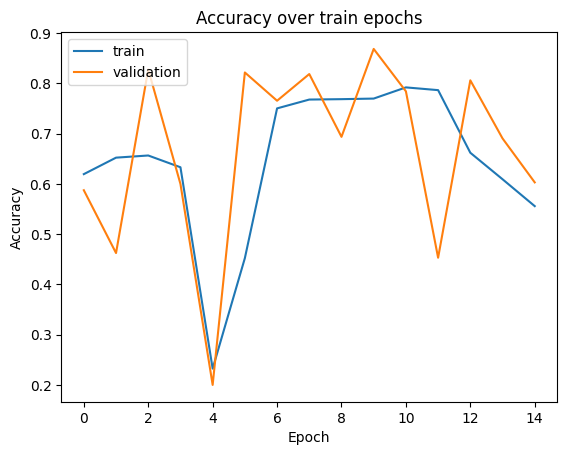

In [63]:
learning_curve(history_mlp_1_1)

In [64]:
print_cofusion_matrix(mlp_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.537
Precision: 0.9701492537313433


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.583
Precision: 0.970873786407767


In [65]:
# Guardamos los pesos de la ultima epoca
mlp_1_1.save_weights("mlp_1_1.h5")

In [66]:
mlp_1_2.compile(**COMPILE_PARAMS) #tanh

mlp_1_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 27648)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2764900   
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [67]:
history_mlp_1_2 = mlp_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 5s 60ms/step - loss: 3.3804 - accuracy: 0.8359 - val_loss: 0.5159 - val_accuracy: 0.8500
Epoch 2/15
79/79 [==============================] - 6s 75ms/step - loss: 0.8768 - accuracy: 0.6828 - val_loss: 0.6678 - val_accuracy: 0.8188
Epoch 3/15
79/79 [==============================] - 4s 52ms/step - loss: 0.7308 - accuracy: 0.4984 - val_loss: 0.6980 - val_accuracy: 0.2031
Epoch 4/15
79/79 [==============================] - 5s 61ms/step - loss: 0.7271 - accuracy: 0.5008 - val_loss: 0.6724 - val_accuracy: 0.8250
Epoch 5/15
79/79 [==============================] - 5s 56ms/step - loss: 0.7588 - accuracy: 0.4699 - val_loss: 0.7176 - val_accuracy: 0.1500
Epoch 6/15
79/79 [==============================] - 5s 59ms/step - loss: 0.7456 - accuracy: 0.4520 - val_loss: 0.6677 - val_accuracy: 0.8438
Epoch 7/15
79/79 [==============================] - 5s 59ms/step - loss: 0.7401 - accuracy: 0.4984 - val_loss: 0.7241 - val_accuracy: 0.1781
Epoch 8/15
79

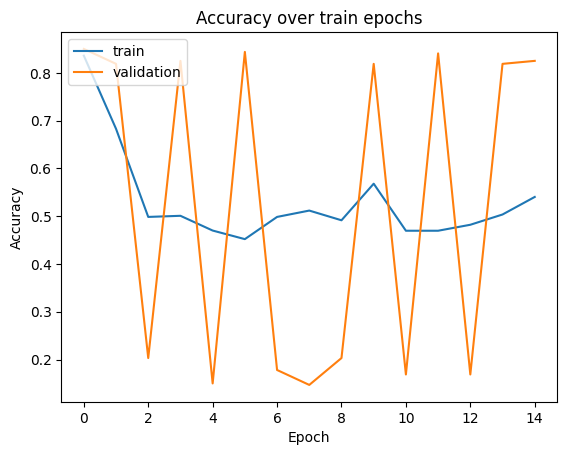

In [68]:
learning_curve(history_mlp_1_2)

In [69]:
print_cofusion_matrix(mlp_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.839
Precision: 0.839


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.817
Precision: 0.817


In [70]:
mlp_1_2.save_weights("mlp_1_2.h5")

In [71]:
mlp_2.compile(**COMPILE_PARAMS)

mlp_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 27648)             0         
                                                                 
 dense_41 (Dense)            (None, 50)                1382450   
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_42 (Dense)            (None, 50)                2550      
                                                                 
 dropout_31 (Dropout)        (None, 50)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,385,051
Trainable params: 1,385,051
N

In [72]:
history_mlp_2 = mlp_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 6s 64ms/step - loss: 1.1246 - accuracy: 0.4039 - val_loss: 0.6955 - val_accuracy: 0.1906
Epoch 2/20
79/79 [==============================] - 3s 43ms/step - loss: 0.7047 - accuracy: 0.1727 - val_loss: 0.6975 - val_accuracy: 0.1562
Epoch 3/20
79/79 [==============================] - 4s 47ms/step - loss: 0.7048 - accuracy: 0.1738 - val_loss: 0.7001 - val_accuracy: 0.2000
Epoch 4/20
79/79 [==============================] - 4s 49ms/step - loss: 0.6782 - accuracy: 0.1566 - val_loss: 0.6952 - val_accuracy: 0.1656
Epoch 5/20
79/79 [==============================] - 4s 46ms/step - loss: 0.6922 - accuracy: 0.1660 - val_loss: 0.6951 - val_accuracy: 0.1719
Epoch 6/20
79/79 [==============================] - 4s 45ms/step - loss: 0.7006 - accuracy: 0.1703 - val_loss: 0.6958 - val_accuracy: 0.2188
Epoch 7/20
79/79 [==============================] - 4s 47ms/step - loss: 0.6845 - accuracy: 0.4531 - val_loss: 0.6934 - val_accuracy: 0.1781
Epoch 8/20
79

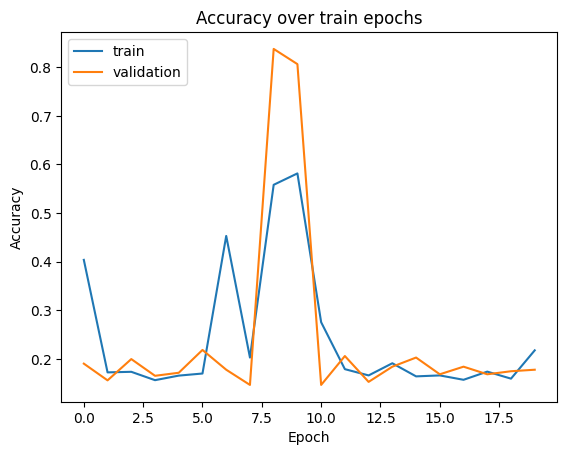

In [73]:
learning_curve(history_mlp_2)

In [74]:
print_cofusion_matrix(mlp_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.166
Precision: 0.0


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.172
Precision: 0.0


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [75]:
mlp_2.save_weights("mlp_2.h5")

In [76]:
mlp_3.compile(**COMPILE_PARAMS)

mlp_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 27648)             0         
                                                                 
 dense_29 (Dense)            (None, 60)                1658940   
                                                                 
 dropout_20 (Dropout)        (None, 60)                0         
                                                                 
 dense_30 (Dense)            (None, 40)                2440      
                                                                 
 dropout_21 (Dropout)        (None, 40)                0         
                                                                 
 dense_31 (Dense)            (None, 20)                820       
                                                                 
 dropout_22 (Dropout)        (None, 20)               

In [77]:
history_mlp_3 = mlp_3.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 4s 43ms/step - loss: 1.4799 - accuracy: 0.4070 - val_loss: 0.7034 - val_accuracy: 0.1688
Epoch 2/15
79/79 [==============================] - 4s 47ms/step - loss: 0.6916 - accuracy: 0.1758 - val_loss: 0.6992 - val_accuracy: 0.1969
Epoch 3/15
79/79 [==============================] - 3s 43ms/step - loss: 0.6929 - accuracy: 0.1656 - val_loss: 0.7002 - val_accuracy: 0.1937
Epoch 4/15
79/79 [==============================] - 3s 43ms/step - loss: 0.7101 - accuracy: 0.1762 - val_loss: 0.7045 - val_accuracy: 0.1344
Epoch 5/15
79/79 [==============================] - 3s 43ms/step - loss: 0.6974 - accuracy: 0.1684 - val_loss: 0.7025 - val_accuracy: 0.1750
Epoch 6/15
79/79 [==============================] - 3s 43ms/step - loss: 0.6775 - accuracy: 0.1562 - val_loss: 0.6957 - val_accuracy: 0.1562
Epoch 7/15
79/79 [==============================] - 3s 43ms/step - loss: 0.6999 - accuracy: 0.1813 - val_loss: 0.6981 - val_accuracy: 0.1531
Epoch 8/15
79

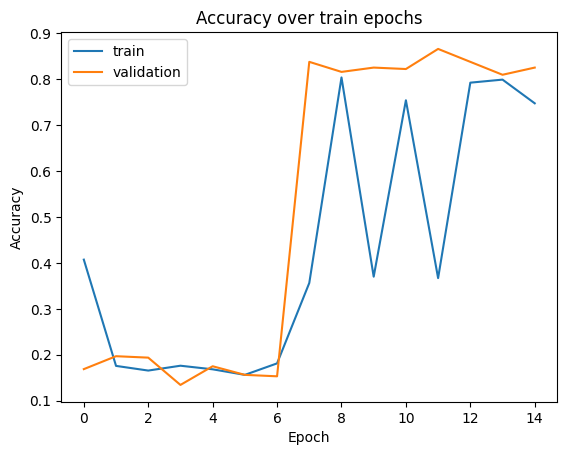

In [78]:
learning_curve(history_mlp_3)

In [79]:
print_cofusion_matrix(mlp_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.807
Precision: 0.807


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.815
Precision: 0.815


In [80]:
mlp_3.save_weights("mlp_3.h5")

In [81]:
mlp_4.compile(**COMPILE_PARAMS)

mlp_4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 27648)             0         
                                                                 
 dense_33 (Dense)            (None, 20)                552980    
                                                                 
 dropout_23 (Dropout)        (None, 20)                0         
                                                                 
 dense_34 (Dense)            (None, 20)                420       
                                                                 
 dropout_24 (Dropout)        (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 20)                420       
                                                                 
 dropout_25 (Dropout)        (None, 20)              

In [82]:
history_mlp_4 = mlp_4.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 4s 39ms/step - loss: 0.7442 - accuracy: 0.3863 - val_loss: 0.7004 - val_accuracy: 0.1406
Epoch 2/20
79/79 [==============================] - 3s 34ms/step - loss: 0.7002 - accuracy: 0.1699 - val_loss: 0.7053 - val_accuracy: 0.1406
Epoch 3/20
79/79 [==============================] - 3s 40ms/step - loss: 0.7027 - accuracy: 0.1715 - val_loss: 0.7016 - val_accuracy: 0.1969
Epoch 4/20
79/79 [==============================] - 3s 35ms/step - loss: 0.6898 - accuracy: 0.1637 - val_loss: 0.6997 - val_accuracy: 0.1813
Epoch 5/20
79/79 [==============================] - 3s 35ms/step - loss: 0.6878 - accuracy: 0.1625 - val_loss: 0.6959 - val_accuracy: 0.2125
Epoch 6/20
79/79 [==============================] - 3s 37ms/step - loss: 0.6942 - accuracy: 0.1664 - val_loss: 0.6961 - val_accuracy: 0.2062
Epoch 7/20
79/79 [==============================] - 3s 36ms/step - loss: 0.6909 - accuracy: 0.1645 - val_loss: 0.6957 - val_accuracy: 0.2000
Epoch 8/20
79

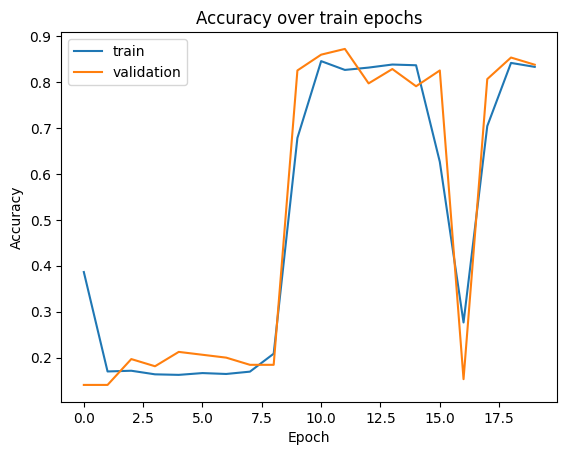

In [83]:
learning_curve(history_mlp_4)

In [84]:
print_cofusion_matrix(mlp_4)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.849
Precision: 0.849


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.821
Precision: 0.821


In [85]:
mlp_4.save_weights("mlp_4.h5")

# Convolutional Neural Networks

In [101]:
# CNN
cnn_1_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_1_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=32, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_3 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=6, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [90]:
cnn_1_1.compile(**COMPILE_PARAMS)

cnn_1_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 dropout_32 (Dropout)        (None, 92, 92, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 flatten_12 (Flatten)        (None, 8464)              0         
                                                                 
 dense_44 (Dense)            (None, 100)               846500    
                                                                 
 dropout_33 (Dropout)        (None, 100)               0         
                                                     

In [91]:
history_cnn_1_1 = cnn_1_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 9s 94ms/step - loss: 0.7630 - accuracy: 0.4754 - val_loss: 0.6884 - val_accuracy: 0.6750
Epoch 2/20
79/79 [==============================] - 8s 94ms/step - loss: 0.6501 - accuracy: 0.6203 - val_loss: 0.6191 - val_accuracy: 0.7469
Epoch 3/20
79/79 [==============================] - 8s 94ms/step - loss: 0.6140 - accuracy: 0.6504 - val_loss: 0.5177 - val_accuracy: 0.8156
Epoch 4/20
79/79 [==============================] - 7s 92ms/step - loss: 0.5556 - accuracy: 0.7172 - val_loss: 0.4248 - val_accuracy: 0.8344
Epoch 5/20
79/79 [==============================] - 7s 89ms/step - loss: 0.5071 - accuracy: 0.7484 - val_loss: 0.4583 - val_accuracy: 0.8031
Epoch 6/20
79/79 [==============================] - 7s 87ms/step - loss: 0.4937 - accuracy: 0.7547 - val_loss: 0.5242 - val_accuracy: 0.7375
Epoch 7/20
79/79 [==============================] - 7s 86ms/step - loss: 0.4670 - accuracy: 0.7629 - val_loss: 0.3981 - val_accuracy: 0.8188
Epoch 8/20
79

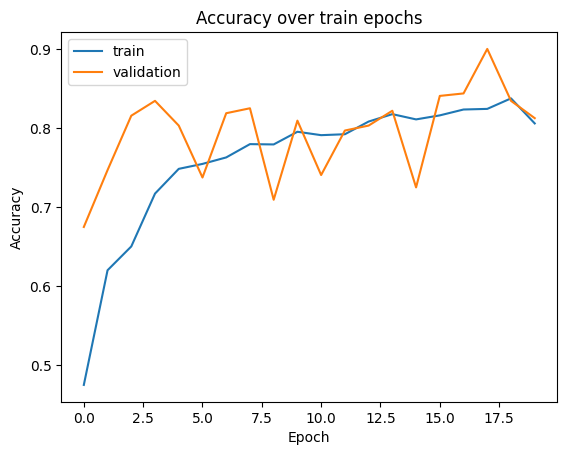

In [92]:
learning_curve(history_cnn_1_1)

In [93]:
print_cofusion_matrix(cnn_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 13ms/step
Accuracy: 0.811
Precision: 0.9597701149425287


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 13ms/step
Accuracy: 0.837
Precision: 0.9702970297029703


In [94]:
cnn_1_1.save_weights("cnn_1_1.h5")

In [95]:
cnn_1_2.compile(**COMPILE_PARAMS)

cnn_1_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 dropout_34 (Dropout)        (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_13 (Flatten)        (None, 16928)             0         
                                                                 
 dense_46 (Dense)            (None, 100)               1692900   
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                     

In [96]:
history_cnn_1_2 = cnn_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 13s 149ms/step - loss: 0.6465 - accuracy: 0.5926 - val_loss: 0.6582 - val_accuracy: 0.5969
Epoch 2/15
79/79 [==============================] - 11s 141ms/step - loss: 0.5315 - accuracy: 0.7176 - val_loss: 0.5938 - val_accuracy: 0.6719
Epoch 3/15
79/79 [==============================] - 11s 144ms/step - loss: 0.4936 - accuracy: 0.7480 - val_loss: 0.5125 - val_accuracy: 0.7125
Epoch 4/15
79/79 [==============================] - 12s 147ms/step - loss: 0.4402 - accuracy: 0.7598 - val_loss: 0.3705 - val_accuracy: 0.8188
Epoch 5/15
79/79 [==============================] - 12s 145ms/step - loss: 0.4349 - accuracy: 0.7703 - val_loss: 0.4329 - val_accuracy: 0.7750
Epoch 6/15
79/79 [==============================] - 11s 136ms/step - loss: 0.4189 - accuracy: 0.7793 - val_loss: 0.3274 - val_accuracy: 0.8344
Epoch 7/15
79/79 [==============================] - 12s 145ms/step - loss: 0.3974 - accuracy: 0.7875 - val_loss: 0.3558 - val_accuracy: 0.8281

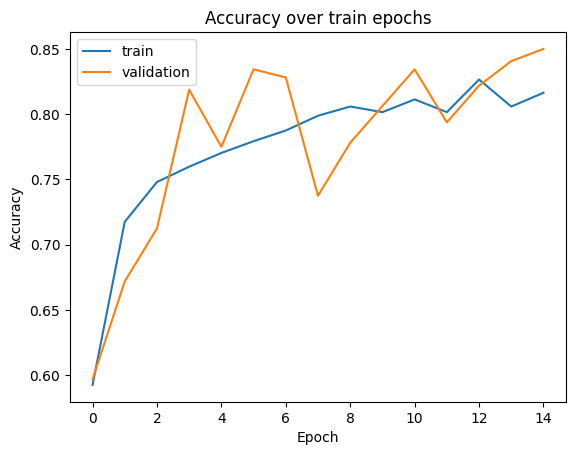

In [97]:
learning_curve(history_cnn_1_2)

In [98]:
print_cofusion_matrix(cnn_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 18ms/step
Accuracy: 0.833
Precision: 0.9641379310344828


######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 18ms/step
Accuracy: 0.832
Precision: 0.9742120343839542


In [100]:
cnn_1_2.save_weights("cnn_1_2.h5")

In [103]:
cnn_2_1.compile(**COMPILE_PARAMS)

cnn_2_1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 8)         224       
                                                                 
 dropout_53 (Dropout)        (None, 94, 94, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 92, 8)         584       
                                                                 
 dropout_54 (Dropout)        (None, 92, 92, 8)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 8)         584       
                                                                 
 dropout_55 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 8)      

In [104]:
history_cnn_2_1 = cnn_2_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 14s 161ms/step - loss: 0.7659 - accuracy: 0.5441 - val_loss: 0.6931 - val_accuracy: 0.4656
Epoch 2/20
79/79 [==============================] - 13s 162ms/step - loss: 0.6619 - accuracy: 0.6648 - val_loss: 0.7177 - val_accuracy: 0.2937
Epoch 3/20
79/79 [==============================] - 13s 162ms/step - loss: 0.6187 - accuracy: 0.6687 - val_loss: 0.6935 - val_accuracy: 0.5125
Epoch 4/20
79/79 [==============================] - 13s 162ms/step - loss: 0.5864 - accuracy: 0.6867 - val_loss: 0.7569 - val_accuracy: 0.3406
Epoch 5/20
79/79 [==============================] - 13s 167ms/step - loss: 0.5768 - accuracy: 0.6883 - val_loss: 0.7094 - val_accuracy: 0.4500
Epoch 6/20
79/79 [==============================] - 13s 164ms/step - loss: 0.5114 - accuracy: 0.7473 - val_loss: 0.5125 - val_accuracy: 0.8000
Epoch 7/20
79/79 [==============================] - 13s 168ms/step - loss: 0.5177 - accuracy: 0.7305 - val_loss: 0.4465 - val_accuracy: 0.8062

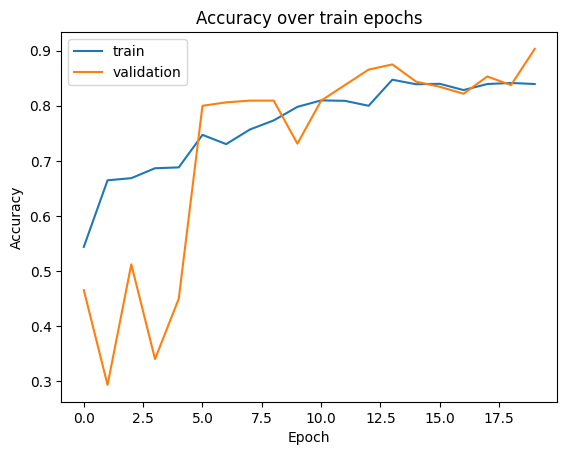

In [105]:
learning_curve(history_cnn_2_1)

In [106]:
print_cofusion_matrix(cnn_2_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 25ms/step
Accuracy: 0.872
Precision: 0.9544863459037711


######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 22ms/step
Accuracy: 0.871
Precision: 0.9660326086956522


In [107]:
cnn_2_1.save_weights("cnn_2_1.h5")

In [108]:
cnn_2_2.compile(**COMPILE_PARAMS)

cnn_2_2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 90, 90, 8)         1184      
                                                                 
 dropout_57 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 84, 84, 8)         3144      
                                                                 
 dropout_58 (Dropout)        (None, 84, 84, 8)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 78, 78, 8)         3144      
                                                                 
 dropout_59 (Dropout)        (None, 78, 78, 8)         0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 8)      

In [109]:
history_cnn_2_2 = cnn_2_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 31s 372ms/step - loss: 0.7657 - accuracy: 0.2484 - val_loss: 0.6957 - val_accuracy: 0.2000
Epoch 2/20
79/79 [==============================] - 31s 392ms/step - loss: 0.6836 - accuracy: 0.3914 - val_loss: 0.6981 - val_accuracy: 0.3625
Epoch 3/20
79/79 [==============================] - 30s 383ms/step - loss: 0.6606 - accuracy: 0.6281 - val_loss: 0.7073 - val_accuracy: 0.3750
Epoch 4/20
79/79 [==============================] - 32s 403ms/step - loss: 0.6539 - accuracy: 0.5648 - val_loss: 0.6535 - val_accuracy: 0.6250
Epoch 5/20
79/79 [==============================] - 33s 410ms/step - loss: 0.5582 - accuracy: 0.7133 - val_loss: 0.5543 - val_accuracy: 0.7219
Epoch 6/20
79/79 [==============================] - 31s 387ms/step - loss: 0.4748 - accuracy: 0.7512 - val_loss: 0.4436 - val_accuracy: 0.8188
Epoch 7/20
79/79 [==============================] - 32s 408ms/step - loss: 0.4400 - accuracy: 0.7844 - val_loss: 0.4719 - val_accuracy: 0.7531

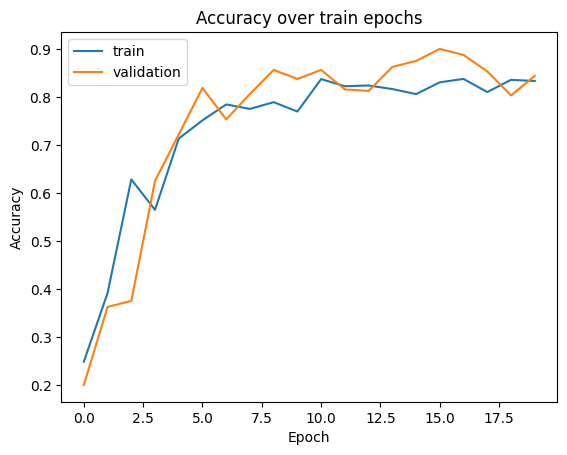

In [110]:
learning_curve(history_cnn_2_2)

In [111]:
print_cofusion_matrix(cnn_2_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 41ms/step
Accuracy: 0.846
Precision: 0.9604221635883905


######################### validation #########################
Samples: 1000
32/32 [==============================] - 2s 49ms/step
Accuracy: 0.853
Precision: 0.9425133689839572


In [112]:
cnn_2_2.save_weights("cnn_2_2.h5")

In [113]:
cnn_3.compile(**COMPILE_PARAMS)

cnn_3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 92, 92, 6)         456       
                                                                 
 dropout_61 (Dropout)        (None, 92, 92, 6)         0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 46, 46, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 21, 21, 16)       0         
 g2D)                                                            
                                                                 
 dropout_62 (Dropout)        (None, 21, 21, 16)      

In [114]:
history_cnn_3 = cnn_3.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 9s 91ms/step - loss: 0.7033 - accuracy: 0.5465 - val_loss: 0.6999 - val_accuracy: 0.1813
Epoch 2/20
79/79 [==============================] - 8s 98ms/step - loss: 0.6970 - accuracy: 0.4742 - val_loss: 0.6103 - val_accuracy: 0.7969
Epoch 3/20
79/79 [==============================] - 7s 91ms/step - loss: 0.6122 - accuracy: 0.6598 - val_loss: 0.5924 - val_accuracy: 0.7000
Epoch 4/20
79/79 [==============================] - 8s 101ms/step - loss: 0.4809 - accuracy: 0.7742 - val_loss: 0.4623 - val_accuracy: 0.7563
Epoch 5/20
79/79 [==============================] - 8s 103ms/step - loss: 0.4659 - accuracy: 0.7660 - val_loss: 0.4885 - val_accuracy: 0.7500
Epoch 6/20
79/79 [==============================] - 7s 90ms/step - loss: 0.3993 - accuracy: 0.7910 - val_loss: 0.3192 - val_accuracy: 0.8156
Epoch 7/20
79/79 [==============================] - 7s 88ms/step - loss: 0.4089 - accuracy: 0.7937 - val_loss: 0.4528 - val_accuracy: 0.7469
Epoch 8/20


In [121]:
best_val_acc_epoch = np.argmax(history_cnn_3.history['val_accuracy'])
cnn_3.set_weights(model_weights_at_epochs[best_val_acc_epoch])

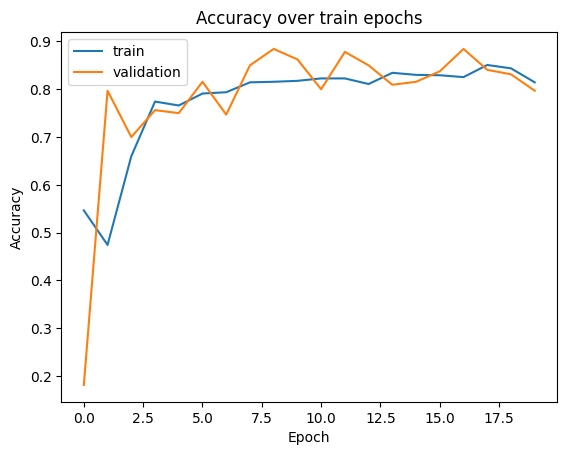

In [115]:
learning_curve(history_cnn_3)

In [123]:
print_cofusion_matrix(cnn_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 15ms/step
Accuracy: 0.845
Precision: 0.9638386648122392


######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 15ms/step
Accuracy: 0.844
Precision: 0.9630642954856361


In [117]:
cnn_3.save_weights("cnn_3.h5")

## Pre-Trained Model

In [129]:
### VGG16
vgg16_model = VGG16(input_shape=(SIZE,SIZE,3), include_top=False)
vgg16_model.trainable = False

pre_trained_model_vgg16 = Sequential([
    vgg16_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])

In [130]:
pre_trained_model_vgg16.compile(**COMPILE_PARAMS)

pre_trained_model_vgg16.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_23 (Flatten)        (None, 4608)              0         
                                                                 
 dense_71 (Dense)            (None, 100)               460900    
                                                                 
 dropout_68 (Dropout)        (None, 100)               0         
                                                                 
 dense_72 (Dense)            (None, 100)               10100     
                                                                 
 dropout_69 (Dropout)        (None, 100)               0         
                                                                 
 dense_73 (Dense)            (None, 1)               

In [131]:
history_pre_trained_model_vgg16 = pre_trained_model_vgg16.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 48s 594ms/step - loss: 0.6258 - accuracy: 0.6406 - val_loss: 0.4656 - val_accuracy: 0.7406
Epoch 2/20
79/79 [==============================] - 50s 627ms/step - loss: 0.5175 - accuracy: 0.7152 - val_loss: 0.5598 - val_accuracy: 0.6812
Epoch 3/20
79/79 [==============================] - 55s 688ms/step - loss: 0.5082 - accuracy: 0.7043 - val_loss: 0.5187 - val_accuracy: 0.7063
Epoch 4/20
79/79 [==============================] - 54s 686ms/step - loss: 0.5017 - accuracy: 0.7227 - val_loss: 0.4906 - val_accuracy: 0.6906
Epoch 5/20
79/79 [==============================] - 48s 605ms/step - loss: 0.4856 - accuracy: 0.7098 - val_loss: 0.5809 - val_accuracy: 0.6531
Epoch 6/20
79/79 [==============================] - 53s 662ms/step - loss: 0.4731 - accuracy: 0.7180 - val_loss: 0.4518 - val_accuracy: 0.7594
Epoch 7/20
79/79 [==============================] - 51s 640ms/step - loss: 0.4573 - accuracy: 0.7398 - val_loss: 0.4254 - val_accuracy: 0.7469

In [132]:
best_val_acc_epoch = np.argmax(history_cnn_3.history['val_accuracy'])
pre_trained_model_vgg16.set_weights(model_weights_at_epochs[best_val_acc_epoch])

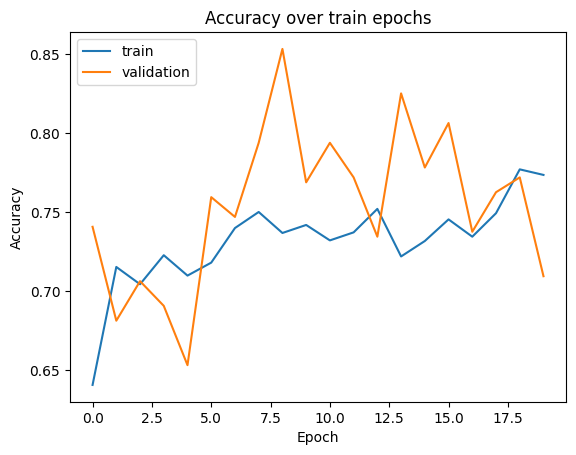

In [133]:
learning_curve(history_pre_trained_model_vgg16)

In [134]:
print_cofusion_matrix(pre_trained_model_vgg16)

######################### train #########################
Samples: 1000
32/32 [==============================] - 18s 565ms/step
Accuracy: 0.816
Precision: 0.9254901960784314


######################### validation #########################
Samples: 1000
32/32 [==============================] - 19s 587ms/step
Accuracy: 0.815
Precision: 0.910941475826972


In [135]:
pre_trained_model_vgg16.save_weights("pre_trained_model_vgg16.h5")